In [1]:
import sys
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from loguru import logger
logger.remove()
logger.add(sys.stderr, level="DEBUG")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Tokenization

### 简介
Tokenization 的主要目的是将文本分解成更小的单位(Tokens)，减小模型输入数据的内在结构复杂度(从句子变为单词序列)，从而简化模型训练的难度。同时将字符的序列转化为Token序号的序列，便于模型输入。

Tokenization 首先确定语言的词表划分粒度，一般可分为：
* 字符级：将文本分解为字符。
* 单词级：将文本分解为单词。
* 子词级：将单词进一步分解为更小的有意义单元（如前缀、后缀）。

之后使用预定义的规则来识别 tokens, 或使用统计或机器学习技术来识别最优的 token 切分方式。例如，BPE（Byte Pair Encoding）或 SentencePiece。

最后实现一组文本序列和Tokens序列之间相互转化的函数，即可完成Tokenization部分。

### 实验要求

1. 实现字符级切分的简单tokenizer， 由 字符表， 字符到token的 encoder()函数 和 token到字符的 decoder() 函数组成。
2. 调用 现有的tokenizer实现，比如openai 的tiktoken

In [2]:
class Tokenizer:
    def __init__(
        self,
        dataPath:str
        ):
        with open(dataPath,"r",encoding="utf-8") as f:
            self.dataset = f.read()
        self.generate_vocabulary()

    def generate_vocabulary(
        self,
        ):
        self.char2index = {}
        self.index2char = {}
        """
        TODO:
        """
        # # start token
        # self.char2index["<START>"] = 0
        # self.index2char[0] = "<START>"
        # # end token
        # self.char2index["<END>"] = 1
        # self.index2char[1] = "<END>"
        # # unknown token
        # self.char2index["<UNK>"] = 2
        # self.index2char[2] = "<UNK>"
        # scan the dataset
        index = 0
        for char in self.dataset:
            if char not in self.char2index:
                self.char2index[char] = index
                self.index2char[index] = char
                index += 1

    def encode(
        self,
        sentence : str,
        ) -> torch.Tensor:
        """
        TODO:
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input  : "ABCD"
        output : Tensor([0,1,2,3])

        注意: 为了后续实验方便，输出Tensor的数据类型dtype 为torch.long。
        """
        for char in sentence:
            if char not in self.char2index:
                sentence = sentence.replace(char, "")
        encoded = [self.char2index.get(char, 2) for char in sentence]
        return torch.tensor(encoded, dtype=torch.long)

    def decode(
        self,
        tokens : torch.Tensor,
        ) -> str:
        """
        TODO:
        例子, 假设A-Z 对应的token是1-26, 句子开始，结束符号的token是0。
        input : Tensor([0,1,2,3])
        output : "ABCD"
        """
        decoded = [self.index2char.get(index.item(), "") for index in tokens]
        return "".join(decoded)

### 定义 dataloader 和 dataset

为了高效加载数据，我们需要把输入文件接入 PyTorch 的数据加载器中。在这里我们定义 `ShakespeareDataset` 类用于加载数据集，用 PyTorch 的 `DataLoader` 类来实现数据加载。


In [3]:
class ShakespeareDataset(Dataset):

    def __init__(self, filepath, tokenizer, chunk_size):
        self.tokenizer = tokenizer
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
        self.encoded = self.tokenizer.encode(text)
        self.chunk_size = chunk_size

    def __len__(self):
        return len(self.encoded) - self.chunk_size

    def __getitem__(self, idx):
        #TODO: 提取一段文本(长度为 chunk_size）作为输入，以及这段文本的每一个字符的下一个字符作为标签
        # example(not correspond to real text): chunk = tensor([ 0, 20, 49, 58, 59])
        #         label = tensor([20, 49, 58, 59, 19])
        # decoded chunk: "The "
        # decoded label: "he T"
        chunk = self.encoded[idx:idx + self.chunk_size]
        label = self.encoded[idx + 1:idx + 1 + self.chunk_size]
        if idx + 1 + self.chunk_size >= len(self.encoded):
            label[-1] = self.encoded[0]
        return chunk, label


tokenizer = Tokenizer(dataPath="input.txt")


def create_dataloader(filepath,
                      tokenizer,
                      chunk_size,
                      batch_size,
                      shuffle=True):
    dataset = ShakespeareDataset(filepath, tokenizer, chunk_size)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset,
        [int(len(dataset) * 0.8),
         len(dataset) - int(len(dataset) * 0.8)])
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=shuffle)
    val_dataloader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=shuffle)
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = create_dataloader('input.txt',
                                                     tokenizer,
                                                     chunk_size=200,
                                                     batch_size=2)


注意力的计算公式为：
$$
Head = Attention(x)=Softmax(M\cdot QK^T)V\\
Q=xW_{q},K=xW_{k}, V=xW_{v}
$$
这里实现的一些数学技巧可以参见attention.ipynb

In [4]:
class HeadAttention(nn.Module):

    def __init__(self, seq_len: int, embed_size: int, hidden_size: int):
        super().__init__()
        # embed_size: dimension for input embedding vector
        # hidden_size: dimension for hidden vector. eg. x:(..., embed_size) --to_q--> query_vector:(..., hidden_size)
        self.hidden_size = hidden_size

        # a triangular bool matrix for mask
        self.register_buffer("tril", torch.tril(torch.ones(seq_len, seq_len)))

        # TODO: init three matrix, to_q, to_k, to_v.
        self.to_q = nn.Linear(embed_size, hidden_size, bias=False)
        self.to_k = nn.Linear(embed_size, hidden_size, bias=False)
        self.to_v = nn.Linear(embed_size, hidden_size, bias=False)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        # return (batch_size, seq_len, hidden_size)
        # TODO: implement the attention mechanism

        # Transform inputs into Query, Key, and Value vectors
        query = self.to_q(inputs)
        key = self.to_k(inputs)
        value = self.to_v(inputs)

        # Compute attention scores (affinity scores)
        attn_scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidden_size, dtype=torch.float32))

        # Apply the mask to the attention scores
        mask = self.tril.to(attn_scores.device)
        attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Weighted sum of values to get context vectors
        context_vecs = torch.matmul(attn_weights, value)

        return context_vecs

Transformer中使用的注意力机制时会使用多个注意力头，期望每个注意力头能够注意到不同的信息。
所以实际公式需要修改如下
$$
MultiHeadAttention(x)=[Head_0, Head_1,...,Head_h]W_o\\
Head_i = Attention(x)=Softmax(M\cdot Q_iK_i^T)V_i\\
Q_i=xW_{iq},K=xW_{ik}, V=xW_{iv}
$$
在搭建网络的过程中，同学们可能会用到nn.ModuleList这个库，每个$Head_i$的计算可以直接使用上面已经实现的单头注意力计算。
最后对于这些注意力头再使用一个简单的线性层/矩阵$W_o$汇总信息即可

In [5]:
class MultiHeadAttention(nn.Module):
    # MultiHeadAttention is consist of many HeadAttention output.
    # concat all this head attention output o_i, then merge them with a projection matrix W_o, as [o_1, o_2, ...] x W_o
    # The reason for using multi-head attention is that we want each head to be able to extract different features
    def __init__(self, n_heads:int, head_size:int, seq_len:int, embed_size:int):
        # n_heads is the number of head attention
        # head_size is the hidden_size in each HeadAttention
        super().__init__()
        head_size = embed_size // n_heads
        #TODO: implement heads and projection
        self.W_o = nn.Linear(n_heads * head_size, embed_size)
        self.head_list = nn.ModuleList([HeadAttention(seq_len, embed_size, head_size) for _ in range(n_heads)])


    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size), make sure embed_size=n_heads x head_size
        # return: (batch_size, seq_len, embed_size)
        # TODO:
        for head in self.head_list:
            head_output = head(inputs)
            if 'outputs' not in locals():
                outputs = head_output
            else:
                outputs = torch.cat((outputs, head_output), dim=-1)
        return self.W_o(outputs)

## 专家网络 Expert

Expert即为标准Transformer中的FeedForward模块。

在经过MultiHeadAttention 模块后，seq_len中的每一个Embedding都对应了前文信息的加权求和。在经过FeedForward模块时，模型对每一个位置的Embedding进行了两次线性变换和一次非线性变换，可以视为对当前语境下的信息进行加工。知识编辑的一些研究表明，FeedForword 模块参数包含了大量的事实性知识。

一个直观的想法是，类比于MultiHeadAttention，我们在每一层训练多个FeedForward模块，对于不同位置的Embedding使用不同的FeedForward模块处理对应的信息。就好像每层有多个Expert,每个Expert都负责处理一类数据的深加工，因此我们称FeedForward为Expert。

实现方面:

FeedForward层由两层简单的线性层组成，对于一个(batch_size, seq_len, embed_size)输入的向量x
只在最后一个维度上进行计算，以实现词的特征维度上的交互(注意力机制是词之间的交互)。
其首先用一个线性层将x最后一维扩大至原先4倍，然后继续用一个线性层还原回原先的维度。

In [6]:
class Expert(nn.Module):
    def __init__(self, embed_size:int):
        super().__init__()
        #TODO: init two linear layer
        self.linear1 = nn.Linear(embed_size, 4 * embed_size)
        self.linear2 = nn.Linear(4 * embed_size, embed_size)

    def forward(self, inputs):
        # inputs: (batch_size, seq_len, embed_size)
        # -> mid: (batch_size, seq_len, 4 x embed_size)
        # -> outputs: (batch_size, seq_len, embed_size)
        mid = torch.relu(self.linear1(inputs))
        outputs = self.linear2(mid)
        return outputs

## 选通网络 TopkRouter

在实现了单个Expert后，我们要设计一个选通网络决策每个Embedding要使用那个Expert计算


### 为了说明选通网络的实现方式，我们定义一下记号：

inputs.shape = [batch_size, seq_len, embed_size] = [1, 8, 16] 

即输入有batch_size=1个数据点，该数据有seq_len长度的context，即包含seq_len=8个Embedding，每个Embedding长度为embed_dim=16。

记 num_expert = 4, 即该层包含 num_expert 个并列的Expert。

记 active_expert = 2, 即计算每个Embedding仅有 active_expert 个Expert 参与计算。

### 选通网络计算
对于有seq_len=8的数据，如果每个Expert都参与计算每一个Embedding，那么一共需要计算 seq_len*embed_size = 32 次， 这极大的增加了模型计算量，因此我们往往只激活其中的active_experts个Expert，这要求我们对每一个Embedding计算最合适的active_experts个 Expert。

对于单个Expert 的原版Transformer来说：

$$
outputs[0,seq] = FeedForward(inputs[0,seq])
$$

对于多个Expert的网络：

$$
outputs[0,seq] = \sum_{i \in range(num\_model)} \alpha_{i} Expert_{i}(inputs[0,seq])
$$

$$
\alpha_{i} = \left\{
\begin{array}{ll}
    1 & Expert_{i}  \text{is selected} \\
    0 & Expert_{i}  \text{is not selected} \\
\end{array}
\right.
$$
将$\{\alpha_0,\alpha_1,\dots,\alpha_{num_experts-1}\}$记为向量$\alpha$:
$$
outputs[0,seq] = \alpha \cdot \{Expert_i(inputs[0,seq])\}
$$

一个选通0,2号Expert的$\alpha$的例子是$[1,0,1,0]$

问题在于如何求得 $\alpha$, 对于一个Embedding ，我们使用神经网络对每个Expert打分，在根据分数计算$\alpha$

$$
score[0,seq] = MLP(inputs[0,seq])  \\
\alpha = topK(score[0,seq])
$$

例如：

$$
score[0,seq] = [11.32,1.54,14.83,-1.90] \\
\alpha = [1,0,1,0]
$$

从优化的角度来说，$\alpha$取前k大的分数的下标（即argmax），这个操作是不可导的，这里我们用之前在"attention.ipynb"中提到的技巧处理这里的计算。

$$
mask(score[0,seq]) = [11.32,-inf,14.83,-inf] \\
\alpha = softmax(mask(score[0,seq])) = [0.028,0,0.971,0] \\
index = [1,0,1,0]
$$

我们用这个$\alpha$和$index$用做选通网络.

In [7]:
# First define the top k router module
class TopkRouter(nn.Module):

    def __init__(self, embed_size, num_experts, active_experts):
        ## TODO
        ## embed_size : dimension of embedding
        ## num_experts : how many Experts per layer
        ## active_experts: only active_experts out of num_experts are selected to process Embeddings per token.
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts

        self.router = nn.Linear(embed_size, num_experts)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inputs):
        ## TODO
        ## 完成这部分时，注意使用Softmax()对router_output做标准化。同时注意这部分所用操作的可导性。
        ## 输入值
        ## inputs is the output tensor from multihead self attention block, shape (B:batch size, T: seq_len, C: embed_size)
        ## 返回值
        ## router_output: normalized weight of Experts, 即教程中的 \alpha
        ## indices:   index of selected Experts, 即教程中的 index
        # score[0,seq] = [11.32,1.54,14.83,-1.90] \\
        # \alpha = [1,0,1,0]
        # ->
        # mask(score[0,seq]) = [11.32,-inf,14.83,-inf] \\
        # \alpha = softmax(mask(score[0,seq])) = [0.028,0,0.971,0] \\
        # index = [1,0,1,0]
        scores = self.router(inputs)
        _, indices = torch.topk(scores, 2, dim=-1)
        mask = torch.ones_like(scores, dtype=torch.bool)
        mask = mask.scatter(-1, indices, False)
        masked_scores = scores.masked_fill(mask, float('-inf'))
        router_output = torch.softmax(masked_scores, -1)
        return router_output, indices

## 稀疏专家网络 SparseMoE

![moe](./moeSparse.png)

在定义完Expert 和 TopkRouter后，我们可以定义SparseMoE模块。

在前向过程中，对于inputs.shape = [Batch_size,seq_len,embed_size]第二维度seq_len个Embedding,我们先利用TopkRouter计算出选通专家序号indices以及专家权重router_output。

我们将Embedding通过选通的Expert得出active_expert个新的Embedding，然后使用router_output的作为权重对新的Embedding加权求和作为输出。


In [8]:
class SparseMoE(nn.Module):
    def __init__(self, embed_size:int, num_experts:int, active_experts:int):
        ## TODO
        super().__init__()
        self.embed_size = embed_size
        self.num_experts = num_experts
        self.active_experts = active_experts
        self.expert_list = nn.ModuleList([Expert(embed_size) for _ in range(num_experts)])
        self.router = TopkRouter(embed_size, num_experts, active_experts)

    def forward(self, inputs):
        ## TODO
        router_output, indices = self.router(inputs)
        final_output = torch.zeros_like(inputs)

        flat_inputs = inputs.view(-1, inputs.size(-1))
        flat_router_output = router_output.view(-1, router_output.size(-1))

        for i, expert in enumerate(self.expert_list):
            expert_mask = (indices == i).any(dim=-1)
            flat_mask = expert_mask.view(-1)

            if flat_mask.any():
                expert_input = flat_inputs[flat_mask]
                expert_output = expert(expert_input)

                alpha = flat_router_output[flat_mask, i].unsqueeze(1)
                weighted_output = expert_output * alpha

                final_output[expert_mask] += weighted_output.squeeze(1)
        return final_output


Transformer由一层层的block堆叠而成，其中每个block的结构从模型的结构图展开中可以看到，由LayerNorm，Masked multi head attention，(SparseMoE)FeedForward组成。

对于一个表示句子的输入向量x，其首先会经过Layer Normalization层.
Layer Normalization 层对于一个 句子个数x句子长度x单词向量维度 的输入 x, 会在最后两维上进行规范化处理，起到稳定训练的作用。

$$
LN(x)=\frac{x-mean(x)}{\sqrt{var(x)+\epsilon}}\cdot\gamma+\beta
$$

其中mean和var都是在最后两个维度上进行的，layernorm的实现同学们可以直接调用nn.LayerNorm
经过layernorm层后，再经过Mask multi head attention层之后，会在+号处再次和原始的输入进行相加，这样的做法能够提高训练的稳定性。有兴趣的同学可以从梯度角度思考原因，或者搜索残差连接相关资料进行学习。
之后再同样经过一层layernorm和feedforwad之后，就可以得到block块的输出了。
即 x' = x+MHA(LN(x)), y = FFN(LN(x'))+x'

In [9]:
class Block(nn.Module):
    # Transformer basic block, consist of MultiHeadAttention, FeedForward and layer normalization
    def __init__(self, embed_size: int, n_heads: int, seq_len: int,
                 num_experts: int, active_experts: int):
        super().__init__()
        # TODO: implement block structure
        # MultiHeadAttention Layer
        self.attention = MultiHeadAttention(n_heads=n_heads,
                                            head_size=embed_size // n_heads,
                                            seq_len=seq_len,
                                            embed_size=embed_size)

        # Layer Normalization after Attention
        self.norm1 = nn.LayerNorm(embed_size)

        # Sparse Mixture-of-Experts Layer
        self.moe = SparseMoE(embed_size=embed_size,
                             num_experts=num_experts,
                             active_experts=active_experts)

        # Layer Normalization after MoE
        self.norm2 = nn.LayerNorm(embed_size)

    def forward(self, inputs):
        # input: (batch_size, seq_len, embed_size)
        #TODO: forward with residual connection
        # MultiHeadAttention
        att_output = self.attention(inputs)  # MultiHeadAttention
        att_output = self.norm1(att_output + inputs)  # Residual connection and layer normalization

        # SparseMoE
        moe_output = self.moe(att_output)  # Sparse Mixture-of-Experts
        moe_output = self.norm2(moe_output + att_output)  # Residual connection and layer normalization

        return moe_output

In [10]:
class SparseMoETransformer(nn.Module):
    # Transformer decoder, consist of
    # token embedding layer and position_embedding(position_embedding 可以理解为对位置编码，感兴趣的同学可以查阅原文，这里可以看为vocab_len = seq_len的Embedding)
    # a stack of Transformer basic block
    # a layernorm and output linear layer
    def __init__(self, vocab_size: int, seq_len: int, embed_size: int,
                 n_layers: int, n_heads: int, num_experts: int,
                 active_experts: int):
        # vocab_size is the number of word in vocabulary dict
        # seq_len is the sequence length/sentence length
        # embed_size is the embedding vector dimension
        super().__init__()
        # TODO:
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size

        # Token Embedding Layer
        self.token_embedding = nn.Embedding(vocab_size, embed_size)

        # Positional Embedding
        self.position_embedding = nn.Embedding(seq_len, embed_size)

        # Stack of Transformer blocks
        self.blocks = nn.Sequential(*[
            Block(embed_size=embed_size, n_heads=n_heads, seq_len=seq_len, num_experts=num_experts, active_experts=active_experts)
            for _ in range(n_layers)
        ])

        # Final LayerNorm
        self.final_norm = nn.LayerNorm(embed_size)

        # Output Linear Layer
        self.output_layer = nn.Linear(embed_size, vocab_size)

    def forward(self, inputs, labels=None):
        # labels: the (ground) true output
        # TODO: implement the forward function of the transformer

        # inputs:(batch_size, seq_len, )
        _, T = inputs.shape
        if T > self.seq_len:
            raise ValueError("input sequence length exceeds the maximum length")
        # embedding:(batch_size, seq_len, embed_size)
        token_embedding = self.token_embedding(inputs)
        position_embedding = self.position_embedding(torch.arange(T, device=inputs.device))
        x = token_embedding + position_embedding
        # attens:(batch_size, seq_len, embed_size)
        x = self.blocks(x)
        # logits:(batch_size, seq_len, vocab_size)
        x = self.final_norm(x)
        logits = self.output_layer(x)

        # compute the loss

        if labels is None:
            loss = None
        else:
            batch_size, seq_len, vocab_size = logits.shape
            logits = logits.view(batch_size * seq_len, vocab_size)
            labels = labels.view(batch_size * seq_len)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        inputs = tokenizer.encode(inputs).unsqueeze(0)
        device = next(self.parameters()).device
        inputs = inputs.to(device)
        if inputs.size(1) > self.seq_len:
            inputs = inputs[:, :self.seq_len]
        if inputs.size(1) < self.seq_len:
            padding_str = " " * (self.seq_len - inputs.size(1))
            padding = tokenizer.encode(padding_str).unsqueeze(0).to(inputs.device)
            inputs = torch.cat([inputs, padding], dim=1)
        generated = inputs
        for _ in range(max_new_tokens):
            if generated.size(1) > self.seq_len:
                generated_input = generated[:, -self.seq_len:]
            else:
                generated_input = generated
            logits, _ = self.forward(generated_input)
            last_logits = logits[:, -1, :]
            next_token_ids = torch.argmax(last_logits, dim=-1)
            next_token_ids = next_token_ids.unsqueeze(-1)
            generated = torch.cat([generated, next_token_ids], dim=1)
        return generated

# 训练循环

如果你已经完成了模型定义等内容，训练的过程实际上在高度封装的 Pytorch 库中非常简单, 因为你并不需要写对应的反向传播。



#### Loss 

Loss 用来**衡量**模型预测与真实值之间的**差距**。

常见的几个 Loss 函数：

* 交叉熵：$\text{CrossEntropy Loss} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$
* 均方误差：$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$
* 绝对误差：$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y_i}|$

不同的 loss 对应不同的优化目标，如果写错 loss 函数会导致模型不收敛/性能很差。

#### 训练循环

当我们写好 Optimizer 和 Loss 之后，对应的训练循环就十分简单了。

我们只需要做以下事情：

* 从 dataloader 里面拿到一个 batch 的数据以及标签
* 将数据送入模型，进行前向传播
* 拿到模型输出的 logits
* 将 logits 和 标签进行 loss 计算
* 用 Optimizer 
    * 清空梯度
    * 反向传播
    * 更新参数

In [11]:
def train(model, dataloader, epoch, device):
    # Optimizer 会根据模型的输出和真实标签计算梯度，然后利用反向传播算法更新模型的参数。
    # 在本实验中你可以将 Optimizer 视作黑盒，只需要知道如何使用即可。
    # 找一个合适的 Optimizer。对不同的任务，模型，最适合的优化器是不一样的，你可以先尝试最常用的 Adam，如果有兴趣可以看看其他的优化器。
    # docs see: https://pytorch.org/docs/stable/optim.html
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    total_loss = 0
    from tqdm import tqdm
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # TODO: implement the training process, and compute the training loss and validation loss
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits, loss = model(inputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # total_loss can not be nan
        if total_loss != total_loss:
            raise ValueError("Loss is nan")

    print(f'Epoch {epoch} Loss: {total_loss / len(dataloader)}')

    return total_loss / len(dataloader)

def validate(model, dataloader, epoch, device):
    model.eval()
    # TODO: 实现验证函数。与训练函数类似，但不需要计算梯度。
    total_loss = 0
    from tqdm import tqdm
    for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        logits, loss = model(inputs, targets)
        total_loss += loss.item()
        if total_loss != total_loss:
            raise ValueError("Loss is nan")

    print(f'Epoch {epoch} Validation Loss: {total_loss / len(dataloader)}')

    return total_loss / len(dataloader)

In [12]:
train_dataloader, valid_dataloader = create_dataloader('input.txt', tokenizer, chunk_size=64, batch_size=2024)
model = SparseMoETransformer(vocab_size=len(tokenizer.char2index), seq_len=64, embed_size=256, n_layers=3, n_heads=8, num_experts=8, active_experts=2).to(device)

100%|██████████| 441/441 [02:03<00:00,  3.58it/s]


Epoch 0 Loss: 1.6476956278829078


100%|██████████| 111/111 [00:09<00:00, 11.61it/s]


Epoch 0 Validation Loss: 1.210537981342625
Epoch 0 Train Loss: 1.6476956278829078, Valid Loss: 1.210537981342625


100%|██████████| 441/441 [02:01<00:00,  3.62it/s]


Epoch 1 Loss: 1.0793107035749354


100%|██████████| 111/111 [00:09<00:00, 11.67it/s]


Epoch 1 Validation Loss: 0.8487004900837803
Epoch 1 Train Loss: 1.0793107035749354, Valid Loss: 0.8487004900837803


100%|██████████| 441/441 [02:02<00:00,  3.59it/s]


Epoch 2 Loss: 0.7142231398834393


100%|██████████| 111/111 [00:09<00:00, 11.74it/s]


Epoch 2 Validation Loss: 0.4828995595107207
Epoch 2 Train Loss: 0.7142231398834393, Valid Loss: 0.4828995595107207


100%|██████████| 441/441 [02:02<00:00,  3.60it/s]


Epoch 3 Loss: 0.4868846118044691


100%|██████████| 111/111 [00:09<00:00, 11.63it/s]


Epoch 3 Validation Loss: 0.324985440518405
Epoch 3 Train Loss: 0.4868846118044691, Valid Loss: 0.324985440518405


100%|██████████| 441/441 [02:02<00:00,  3.61it/s]


Epoch 4 Loss: 0.3788902074301324


100%|██████████| 111/111 [00:09<00:00, 11.71it/s]


Epoch 4 Validation Loss: 0.2891933952902888
Epoch 4 Train Loss: 0.3788902074301324, Valid Loss: 0.2891933952902888


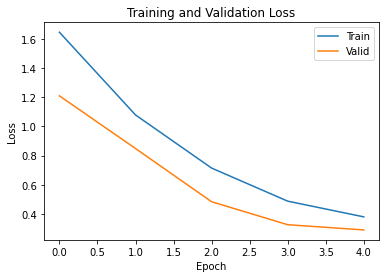

In [13]:

def plot(train_losses, valid_losses):
    import matplotlib.pyplot as plt
    epochs = len(train_losses)
    plt.plot(range(epochs), train_losses, label='Train')
    if valid_losses is not None:
        plt.plot(range(epochs), valid_losses, label='Valid')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.savefig('loss.png')

# 训练模型
def run(model, train_dataloader, valid_dataloader, device, epochs=10):
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, epoch, device)
        valid_loss = validate(model, valid_dataloader, epoch, device)
        print(f'Epoch {epoch} Train Loss: {train_loss}, Valid Loss: {valid_loss}')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    plot(train_losses, valid_losses)

#TODO: 用 matplotlib plot 训练过程中的 loss 变化

run(model, train_dataloader, valid_dataloader, device, epochs=5)

# 保存模型
torch.save(model.state_dict(), 'model.pth')

In [14]:
model.load_state_dict(torch.load('model.pth'))

print(tokenizer.decode(model.generate("I could pick my lance",max_new_tokens=100)[0]))

I could pick my lance                                           order?

BUCKINGHAM:
And, in good time, here the lieutenant comes.
Master lieutenant, pray you, by yo
